In [2]:
import pandas as pd
from pyopenms import MzMLFile, MSExperiment, OnDiscMSExperiment
import numpy as np
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
mapping_df_all = pd.read_csv("../../data/230928_JL_Immonium_ions_Modified_DIA_id_mapping.csv", index_col="renamed_id")


In [4]:
def get_id_number(id_string):
    return int(re.findall("[0-9]+", id_string)[-1])

def get_id_number_from_name(spectrum):
    return re.findall("scan=[0-9]+",spectrum.getMetaValue("spectrum title"))[0][5:]

In [5]:
def get_higher_energy_scan_id(id_string):
    id_number = get_id_number(id_string)
    higher_energy_id_number = id_number + 36
    return f"controllerType=0 controllerNumber=1 scan={higher_energy_id_number}"

In [6]:
def get_df_with_original_and_higher_energy_id_mapped(df, exp, mapping_df):
    df = df.copy()
    ms2_spectra = np.array([spectrum for spectrum in exp.getSpectra() if spectrum.getMSLevel() == 2])
    ms2_spectra_in_df = ms2_spectra[df["MS2.Scan"].to_numpy()]
    df.insert(len(df.columns), "remapped_ids", [s.getNativeID() for s in ms2_spectra_in_df])
    df.insert(len(df.columns), "original_ids", [mapping_df.loc[remapped_id]["original_id"] for remapped_id in df["remapped_ids"]])
    higher_energy_id_number = np.array([get_id_number(get_higher_energy_scan_id(id)) for id in df["original_ids"]])
    df.insert(len(df.columns), "higher_energy_ids", higher_energy_id_number)
    return df

In [7]:
exp_all = MSExperiment()
MzMLFile().load("../../data/230928_JL_Immonium_ions_Modified_DIA_lower_energy.mzML", exp_all)

In [8]:
mod_acetyl = ("acetyl","K(UniMod:1)")
mod_biotin = ("biotin","K(UniMod:3)")
mod_dimethyl = ("dimethyl","K(UniMod:36)")
mod_hydroxy = ("hydroxy","P(UniMod:35)")
mod_oxid = ("oxid","P(UniMod:35)")
mod_methyl = ("methyl","K(UniMod:34)")
mod_nitro = ("nitro","Y(UniMod:354)")
mod_phospho = ("phospho","Y(UniMod:21)")

In [9]:
mods_results = {}
for mod_name, mod_unimod in [mod_acetyl, mod_biotin, mod_dimethyl, mod_hydroxy, mod_methyl, mod_nitro, mod_phospho]:
    exp_subset = MSExperiment()
    MzMLFile().load(f"../../data/workflow_test_tolerance_snr3_10ppm_all_mods/lower_energy_windows_{mod_unimod}.mzML", exp_subset)
    mapping_df_subset = pd.read_csv(f"../../data/workflow_test_tolerance_snr3_10ppm_all_mods/spectrum_id_mapping_{mod_unimod}.csv", index_col="renamed_id")
    df_mod_all = get_df_with_original_and_higher_energy_id_mapped(pd.read_csv(f"../../data/diann_results/dia_nn_results_filtered/report_filtered_{mod_name}_all_spectra.tsv", delimiter="\t"), exp_all, mapping_df_all)
    df_mod_subset = get_df_with_original_and_higher_energy_id_mapped(pd.read_csv(f"../../data/workflow_test_tolerance_snr3_10ppm_all_mods/report_{mod_unimod}.tsv", delimiter="\t"), exp_subset, mapping_df_subset)

    if mod_name == "hydroxy":
        mod_name = "oxid"
    mods_results[(mod_name, mod_unimod)] = {"df_all": df_mod_all, "df_subset": df_mod_subset}

In [8]:
phospho_hydroxy_df_all = get_df_with_original_and_higher_energy_id_mapped(pd.read_csv(f"../../data/diann_results/dia_nn_results_filtered/report_filtered_phospho_hydroxy_all_spectra.tsv", delimiter="\t"), exp_all, mapping_df_all)
exp_phospho_subset = MSExperiment()
MzMLFile().load(f"../../data/workflow_test_tolerance_snr3_10ppm_all_mods/lower_energy_windows_Y(UniMod:21).mzML", exp_phospho_subset)
mapping_df_phospho_subset = pd.read_csv(f"../../data/workflow_test_tolerance_snr3_10ppm_all_mods/spectrum_id_mapping_Y(UniMod:21).csv", index_col="renamed_id")
phospho_hydroxy_df_subset = get_df_with_original_and_higher_energy_id_mapped(pd.read_csv(f"../../data/diann_results/dia_nn_results_filtered/report_filtered_phospho_hydroxy.tsv", delimiter="\t"), exp_phospho_subset, mapping_df_phospho_subset)

In [11]:
def get_detected_ions_for_mod(ions_df, mod_unimod):
    ions_df = ions_df.copy()
    ions_df.insert(len(ions_df.columns), "id_numbers", [get_id_number(id) for id in ions_df["spectrum_id"]])
    return ions_df[ions_df["letter_and_unimod_format_mod"] == mod_unimod]

In [12]:
detected_ions_df = pd.read_csv("../../data/workflow_test_tolerance_snr3_10ppm_all_mods/detected_ions.csv")

phospho_detected = get_detected_ions_for_mod(detected_ions_df, "Y(UniMod:21)")
detected_ids_phopspho = phospho_detected["id_numbers"]

In [ ]:
len(detected_ions_df[detected_ions_df["mod_name"] != "unmodified"]["spectrum_id"].unique())

In [ ]:
len(phospho_detected)

In [42]:
def plot_in_mod_window_all_spectra():
    # from https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
    stacked_bars = {"in mod ion window": [], "not in mod ion window": []}
    mod_names = []
    fig, ax = plt.subplots()
    for mod, mod_data in mods_results.items():
        mod_name, mod_unimod = mod
        mod_names.append(mod_name)

        df_all = mod_data["df_all"]
        
        df_precursors_mod = df_all[df_all["Modified.Sequence"].str.contains(re.escape(mod_unimod))]

        detected_mod_df = get_detected_ions_for_mod(detected_ions_df, mod_unimod)
        result_in_detected_windows_df = df_precursors_mod[df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
        result_not_in_detected_windows_df = df_precursors_mod[~df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
        num_in_detected_windows = len(result_in_detected_windows_df)
        num_not_in_detected_windows = len(result_not_in_detected_windows_df)

        stacked_bars["in mod ion window"].append(num_in_detected_windows)
        stacked_bars["not in mod ion window"].append(num_not_in_detected_windows)

    width = 0.5
    bottom = np.zeros(len(mod_names))

    for window_boolean, mod_count in stacked_bars.items():
        p = ax.bar(mod_names, mod_count, width, label=window_boolean, bottom=bottom)
        bottom += mod_count
    
    #ax.set_title("in VS not in mod ion window")
    ax.legend(loc="upper right")
    ax.set_ylabel("Number of found precursors with modification")
    plt.savefig("../../data/plots/all_mods_in_detected_all_spectra.png", bbox_inches="tight")

    plt.show()
                

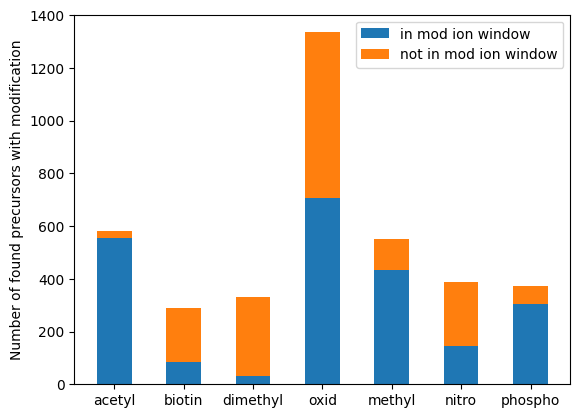

In [43]:
plot_in_mod_window_all_spectra()

In [55]:
def plot_all_spectra_vs_subset():
    mod_names = []
    nums_subset_mod_precursors = []
    nums_all_mod_precursors = []

    for mod, mod_data in mods_results.items():
        mod_name, mod_unimod = mod
        mod_names.append(mod_name)

        df_all = mod_data["df_all"]
        df_subset = mod_data["df_subset"]
        
        df_all_precursors_mod = df_all[df_all["Modified.Sequence"].str.contains(re.escape(mod_unimod))]

        subset_matching_windows = df_subset.merge(df_all, on="original_ids", suffixes=("_subset", "_all"))
        subset_matching_windows_precursors = subset_matching_windows[subset_matching_windows["Precursor.Id_subset"] == subset_matching_windows["Precursor.Id_all"]]

        qvalue = subset_matching_windows_precursors["Q.Value_subset"].max()
        df_subset_passing_precursors = df_subset[df_subset["Q.Value"] < qvalue]
        df_subset_passing_precursors_mod = df_subset_passing_precursors[df_subset_passing_precursors["Modified.Sequence"].str.contains(re.escape(mod_unimod))]

        nums_all_mod_precursors.append(len(df_all_precursors_mod))
        nums_subset_mod_precursors.append(len(df_subset_passing_precursors_mod))

    x = np.arange(len(mod_names))
    width = 0.25

    fig, ax = plt.subplots()

    ax.bar_label(ax.bar(x, nums_all_mod_precursors, width, label="search in all spectra"), padding=3)

    ax.bar_label(ax.bar(x + width, nums_subset_mod_precursors, width, label="search in mod\nion windows"), padding=3)

    ax.set_ylabel('Number of found precursors with modifications')
    #ax.set_title(f"Number of detected diagnostic ions for different {xlabel}")
    ax.set_xticks(x + width/2, mod_names)
    ax.legend(loc="upper right")
    #ax.set_ylim(0, 250)

    plt.savefig(f"../../data/plots/all_mods_all_spectra_vs_subset.png", bbox_inches="tight")
    plt.show()


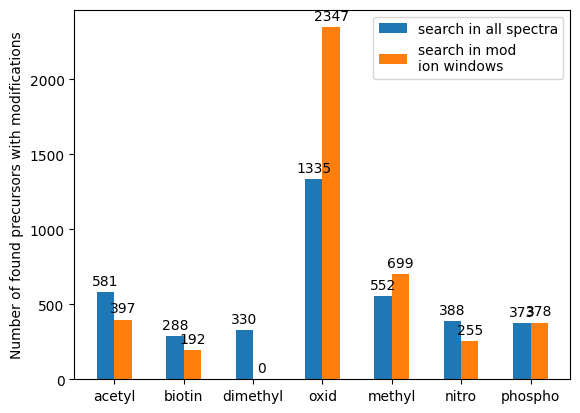

In [56]:
plot_all_spectra_vs_subset()

In [12]:
def sankey_for_analysis_on_all_spectra(df_all, mod_unimod, mod_name):
  num_precursors_all = len(df_all)
  df_precursors_mod = df_all[df_all["Modified.Sequence"].str.contains(re.escape(mod_unimod))]
  num_precursors_mod = len(df_precursors_mod)

  detected_mod_df = get_detected_ions_for_mod(detected_ions_df, mod_unimod)
  result_in_detected_windows_df = df_precursors_mod[df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  result_not_in_detected_windows_df = df_precursors_mod[~df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  num_in_detected_windows = len(result_in_detected_windows_df)
  num_not_in_detected_windows = len(result_not_in_detected_windows_df)

  get_from_synthetic_protein_df = lambda input_df: input_df[input_df["Protein.Ids"].str.contains("X0000")]

  from_synthetic_protein_df = get_from_synthetic_protein_df(df_precursors_mod)
  num_detected_windows_synthetic = len(get_from_synthetic_protein_df(result_in_detected_windows_df))
  num_detected_windows_not_synthetic = len(result_in_detected_windows_df) - num_detected_windows_synthetic
  num_not_detected_windows_synthetic = len(get_from_synthetic_protein_df(result_not_in_detected_windows_df))
  num_not_detected_windows_not_synthetic = len(result_not_in_detected_windows_df) - num_not_detected_windows_synthetic

  num_kmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00001").sum()
  num_pmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00002").sum()
  num_ymod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00005").sum()


  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [f"all precursors<br>{num_precursors_all}",
                 f"{mod_name}<br>{num_precursors_mod}",
                 f"unmod<br>{num_precursors_all - num_precursors_mod}",
                 f"in {mod_name} ion window<br>{num_in_detected_windows}",
                 f"not in {mod_name} ion window<br>{num_not_in_detected_windows}",
                 f"from synthetic protein<br>{num_detected_windows_synthetic + num_not_detected_windows_synthetic}",
                 f"not from synthetic protein<br>{num_detected_windows_not_synthetic + num_not_detected_windows_not_synthetic}",
                 f"Kmod<br>{num_kmod}",
                 f"Pmod<br>{num_pmod}",
                 f"Ymod<br>{num_ymod}"],
        color = "blue"
      ),
      link = dict(
        source = [0, 0, 1, 1, 3, 4, 3, 4, 5, 5, 5], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9],
        value = [num_precursors_mod,
                 num_precursors_all - num_precursors_mod,
                 num_in_detected_windows,
                 num_not_in_detected_windows,
                 num_detected_windows_synthetic,
                 num_not_detected_windows_synthetic,
                 num_detected_windows_not_synthetic,
                 num_not_detected_windows_not_synthetic,
                 num_kmod, num_pmod, num_ymod]
    ))])

  fig.update_layout(title_text=f"{mod_name} all spectra", font_size=14, font_color="black")
  fig.show()

In [13]:
for mod, mod_data in mods_results.items():
    mod_name, mod_unimod = mod
    sankey_for_analysis_on_all_spectra(mod_data["df_all"], mod_unimod, mod_name)

In [14]:
def sankey_for_analysis_on_subset_spectra_comparison_all_matching_windows(df_all, df_subset, mod_unimod):# amino_acid, mod_name):
  num_subset = len(df_subset)
  subset_matching_windows = df_subset.merge(df_all, on="original_ids", suffixes=("_subset", "_all"))
  subset_matching_windows_precursors = subset_matching_windows[subset_matching_windows["Precursor.Id_subset"] == subset_matching_windows["Precursor.Id_all"]]
  num_matching_windows_precursors = len(subset_matching_windows_precursors)
  # subset_matching_precursors = df_subset.merge(df_all, on="Precursor.Id", suffixes=("_subset", "_all"))
  # num_matching_precursors = len(subset_matching_precursors)


  # num_precursors_all = len(df_all)
  df_precursors_mod = subset_matching_windows_precursors[subset_matching_windows_precursors["Modified.Sequence_subset"].str.contains(re.escape(mod_unimod))]
  df_precursors_unmod = subset_matching_windows_precursors[~subset_matching_windows_precursors["Modified.Sequence_subset"].str.contains(re.escape(mod_unimod))]
  num_precursors_mod = len(df_precursors_mod)
  num_precursors_unmod = len(df_precursors_unmod)

  # detected_mod_df = get_detected_ions_for_mod(detected_ions_df, amino_acid, mod_name)
  # result_in_detected_windows_df = df_precursors_mod[df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  # result_not_in_detected_windows_df = df_precursors_mod[~df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  # num_in_detected_windows = len(result_in_detected_windows_df)
  # num_not_in_detected_windows = len(result_not_in_detected_windows_df)

  from_synthetic_protein_df = df_precursors_mod[df_precursors_mod["Protein.Ids_subset"].str.contains("X0000")]
  num_mod_synthetic = len(from_synthetic_protein_df)
  num_mod_not_synthetic = num_precursors_mod - num_mod_synthetic

  num_kmod = from_synthetic_protein_df["Protein.Ids_subset"].str.contains("X00001").sum()
  num_pmod = from_synthetic_protein_df["Protein.Ids_subset"].str.contains("X00002").sum()
  num_ymod = from_synthetic_protein_df["Protein.Ids_subset"].str.contains("X00005").sum()


  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [f"subset precursors<br>{num_subset}",
                 f"matching all-spectra result<br>{num_matching_windows_precursors}",
                 f"not matching all-spectra result<br>{num_subset - num_matching_windows_precursors}",
                 f"{mod_name}<br>{num_precursors_mod}",
                 f"unmod<br>{num_precursors_unmod}",
                 f"from synthetic protein<br>{num_mod_synthetic}",
                 f"not from synthetic protein<br>{num_mod_not_synthetic}",
                 f"Kmod<br>{num_kmod}",
                 f"Pmod<br>{num_pmod}",
                 f"Ymod<br>{num_ymod}"
                 ],
        color = "blue"
      ),
      link = dict(
        source = [0, 0, 1, 1, 3, 3, 5, 5, 5], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [1, 2, 3, 4, 5, 6, 7, 8, 9],
        value = [num_matching_windows_precursors, num_subset - num_matching_windows_precursors,
                 num_precursors_mod, num_precursors_unmod,
                 num_mod_synthetic,
                 num_mod_not_synthetic,
                 num_kmod, num_pmod, num_ymod]
    ))])

  fig.update_layout(title_text=f"{mod_name} subset matching precursors", font_size=14, font_color="black")
  fig.show()

In [15]:
for mod, mod_data in mods_results.items():
    mod_name, mod_unimod = mod
    sankey_for_analysis_on_subset_spectra_comparison_all_matching_windows(mod_data["df_all"], mod_data["df_subset"], mod_unimod)

In [20]:
def sankey_for_analysis_on_subset_spectra_filtered_qvalue(df_all, df_subset, mod_unimod):# amino_acid, mod_name):
  num_subset = len(df_subset)
  subset_matching_windows = df_subset.merge(df_all, on="original_ids", suffixes=("_subset", "_all"))
  subset_matching_windows_precursors = subset_matching_windows[subset_matching_windows["Precursor.Id_subset"] == subset_matching_windows["Precursor.Id_all"]]

  qvalue = subset_matching_windows_precursors["Q.Value_subset"].max()
  subset_filtered = df_subset[df_subset["Q.Value"] < qvalue]
  num_passing_qvalue = len(subset_filtered)
  num_not_qvalue = num_subset - num_passing_qvalue

  # num_precursors_all = len(df_all)
  df_precursors_mod = subset_filtered[subset_filtered["Modified.Sequence"].str.contains(re.escape(mod_unimod))]
  df_precursors_unmod = subset_filtered[~subset_filtered["Modified.Sequence"].str.contains(re.escape(mod_unimod))]
  num_precursors_mod = len(df_precursors_mod)
  num_precursors_unmod = len(df_precursors_unmod)

  from_synthetic_protein_df = df_precursors_mod[df_precursors_mod["Protein.Ids"].str.contains("X0000")]
  num_mod_synthetic = len(from_synthetic_protein_df)
  num_mod_not_synthetic = num_precursors_mod - num_mod_synthetic
  num_kmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00001").sum()
  num_pmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00002").sum()
  num_ymod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00005").sum()


  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [f"subset precursors<br>{num_subset}",
                 f"passing qvalue of {qvalue}<br>{num_passing_qvalue}",
                 f"not passing qvalue<br>{num_not_qvalue}",
                 f"{mod_name}<br>{num_precursors_mod}",
                 f"unmod<br>{num_precursors_unmod}",
                 f"from synthetic protein<br>{num_mod_synthetic}",
                 f"not from synthetic protein<br>{num_mod_not_synthetic}",
                 f"Kmod<br>{num_kmod}",
                 f"Pmod<br>{num_pmod}",
                 f"Ymod<br>{num_ymod}"
                 ],
        color = "blue"
      ),
      link = dict(
        source = [0, 0, 1, 1, 3, 3, 5, 5, 5], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [1, 2, 3, 4, 5, 6, 7, 8, 9],
        value = [num_passing_qvalue,
                 num_not_qvalue,
                 num_precursors_mod, num_precursors_unmod,
                 num_mod_synthetic,
                 num_mod_not_synthetic,
                 num_kmod, num_pmod, num_ymod]
    ))])

  fig.update_layout(title_text=f"{mod_name} subset filtered q-value", font_size=14, font_color="black")
  fig.show()

In [17]:
sankey_for_analysis_on_subset_spectra_filtered_qvalue(phospho_hydroxy_df_all, phospho_hydroxy_df_subset, "Y(UniMod:21)")

NameError: name 'phospho_hydroxy_df_all' is not defined

In [21]:
for mod, mod_data in mods_results.items():
    mod_name, mod_unimod = mod
    sankey_for_analysis_on_subset_spectra_filtered_qvalue(mod_data["df_all"], mod_data["df_subset"], mod_unimod)

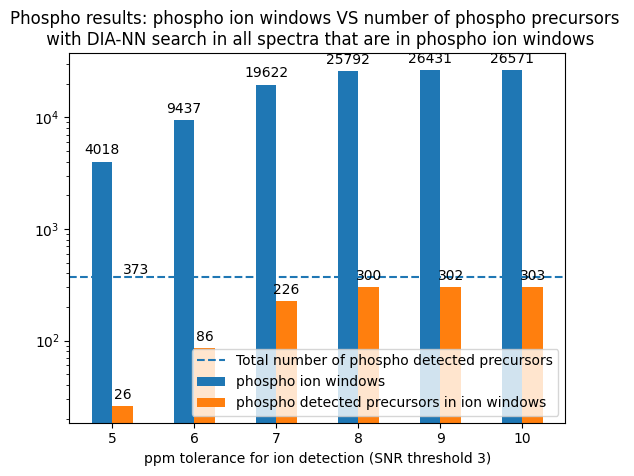

In [21]:
phospho_ion_windows_per_ppm = []
phospho_precursors_in_ion_windows_per_ppm = []
phospho_precursors_all = mods_results[mod_phospho]["df_all"]
phospho_precursors_all = phospho_precursors_all[phospho_precursors_all["Modified.Sequence"].str.contains(re.escape("Y(UniMod:21)"))]
ppms = np.array([5, 6, 7, 8, 9, 10])
for ppm in ppms:
    df_ppm = pd.read_csv(f"../../data/result_csvs/230928_JL_Immonium_ions_Modified_DIA.mzML_diagnostic_ions_ppm_tolerance_{ppm}_snr_threshold_3_unimod.csv")
    phospho_detected_ppm = get_detected_ions_for_mod(df_ppm, "Y(UniMod:21)")
    detected_ids_phospho_ppm = phospho_detected_ppm["id_numbers"]
    in_phospho_detected_all_ppm = phospho_precursors_all[phospho_precursors_all["higher_energy_ids"].isin(detected_ids_phospho_ppm)]
    phospho_ion_windows_per_ppm.append(len(phospho_detected_ppm))
    phospho_precursors_in_ion_windows_per_ppm.append(len(in_phospho_detected_all_ppm))

width = 0.25
fig, ax = plt.subplots()

ax.bar_label(ax.bar(ppms, phospho_ion_windows_per_ppm, width, label="phospho ion windows"), padding=3)

ax.bar_label(ax.bar(ppms + width, phospho_precursors_in_ion_windows_per_ppm, width, label=f"phospho detected precursors in ion windows"), padding=3)
ax.axhline(len(phospho_precursors_all), label="Total number of phospho detected precursors", linestyle="dashed")
ax.text(ppms[0] + width, len(phospho_precursors_all) + 20, len(phospho_precursors_all))

ax.set_xlabel("ppm tolerance for ion detection (SNR threshold 3)")
ax.set_title("Phospho results: phospho ion windows VS number of phospho precursors \n with DIA-NN search in all spectra that are in phospho ion windows")
plt.legend(loc="lower right")
ax.set_xticks(ppms + width/2, ppms)
ax.set_yscale("log")
plt.savefig("../../data/plots/phospho_results_all_spectra_in_vs_not_in_ion_window.png", bbox_inches="tight")
plt.show()

In [28]:
mods_results[mod_phospho]["df_all"].iloc[0]

File.Name                   /hpi/fs00/home/andrea.nathansen/proteomics_dat...
Run                         230928_JL_Immonium_ions_Modified_DIA_lower_energy
Protein.Group                                                          P27694
Protein.Ids                                                     P27694;X00001
Protein.Names                                                      RFA1_HUMAN
Genes                                                                    RPA1
PG.Quantity                                                        11174700.0
PG.Normalised                                                      11174700.0
PG.MaxLFQ                                                          11174700.0
Genes.Quantity                                                     11174700.0
Genes.Normalised                                                   11174700.0
Genes.MaxLFQ                                                       11174700.0
Genes.MaxLFQ.Unique                                             

In [ ]:
tolerance_margin = 216.042 * 10 / 1e6
print(216.042 - tolerance_margin, 216.042 + tolerance_margin)

In [12]:
def ion_detection(spectrum):
    spectrum_mz, intensities = spectrum.get_peaks()
    lower_border = np.searchsorted(spectrum_mz, 216.042 - tolerance_margin, side="left")
    higher_border = np.searchsorted(spectrum_mz, 216.042 + tolerance_margin, side="right")

    detected_peaks_mz = spectrum_mz[lower_border:higher_border]
    detected_peaks_intensities = intensities[lower_border:higher_border]
    if len(detected_peaks_mz) == 0:
        return None, 0
    max_peak_idx = np.argmax(detected_peaks_intensities)
    max_peak_mz = detected_peaks_mz[max_peak_idx]
    max_peak_intensity = detected_peaks_intensities[max_peak_idx]
    return max_peak_mz, max_peak_intensity

In [ ]:
for id_number in not_in_phospho_detected_all:
    s = od_exp.getSpectrumByNativeId(f"controllerType=0 controllerNumber=1 scan={id_number}")
    max_peak_mz, max_peak_intensity = ion_detection(s)
    if max_peak_mz is None:
        print(f"None found for {id_number}")
        print(detected_ions_df[detected_ions_df["spectrum_id"] == s.getNativeID()])
        continue
    print(id_number, max_peak_intensity < s.get_peaks()[1].mean())

In [13]:
def plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(s_id_number):
    current_ms1_intensities = []
    previous_ms1_intensities = []
    spectrum_idcs = []
    phospho_precursor_idcs = []
    spectra = exp_all.getSpectra()
    phospho_precursors_all = mods_results[mod_phospho]["df_all"]

    initial_spectrum_idx = [i[0] for i in enumerate(spectra) if i[1].getNativeID() == f"controllerType=0 controllerNumber=1 scan={s_id_number}"][0]
    ms1_spectrum_idx = exp_all.getPrecursorSpectrum(initial_spectrum_idx)
    spectrum_idx = ms1_spectrum_idx + 1

    current_spectrum = spectra[spectrum_idx]
    while current_spectrum.getMSLevel() == 2:
        if current_spectrum.getPrecursors()[0].getMetaValue("collision energy") == 50:
            current_ms1_intensity = ion_detection(current_spectrum)[1]
            previous_ms1_intensity = ion_detection(spectra[spectrum_idx - 73])[1]
            current_ms1_intensities.append(current_ms1_intensity)
            previous_ms1_intensities.append(previous_ms1_intensity)
            spectrum_idcs.append(spectrum_idx)
            if get_id_number(current_spectrum.getNativeID()) in phospho_precursors_all["higher_energy_ids"].to_numpy():
                phospho_precursor_idcs.append(spectrum_idx)

        spectrum_idx += 1
        current_spectrum = spectra[spectrum_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(spectrum_idcs, previous_ms1_intensities, label="immonium ions in windows for previous MS1 window", marker="o", color="orange")
    plt.plot(spectrum_idcs, current_ms1_intensities, label="immonium ions in windows for current MS1 window", marker="o")
    
    # for precursor_idx in phospho_precursor_idcs:
    #     color = "g" if get_id_number(spectra[precursor_idx].getNativeID()) in in_phospho_detected_all else "r"
    #     plt.axvline(precursor_idx, color=color)
    #plt.axvline(initial_spectrum_idx, color="violet")
    plt.legend(loc="upper right")


In [14]:
plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(75897)

IndexError: list index out of range

In [ ]:
plt.bar(*od_exp.getSpectrumByNativeId("controllerType=0 controllerNumber=1 scan=75897").get_peaks())
plt.axvline(216.042, color="orange")

In [ ]:
detected_ions_df[detected_ions_df["spectrum_id"] == "controllerType=0 controllerNumber=1 scan=75897"]

In [ ]:
plot_phospho_ions_behaviour_for_spectrum_id_within_mz_range(75897)

In [ ]:
for id in phospho_precursors_all["higher_energy_ids"].to_numpy()[:20]:
    plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(id)

In [57]:
plt.close()